<a href="https://colab.research.google.com/github/SharatGupta/DSML-Projects/blob/main/Zee_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import re

!pip install category_encoders
from category_encoders import TargetEncoder
# !pip install sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, MinMaxScaler

from scipy.stats import pearsonr

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.neighbors import NearestNeighbors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


In [245]:
!pip install cmfrec
from cmfrec import CMF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.23-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post8-cp310-cp310-linux_x86_64.whl size=5830777 sha256=6d51f7b5d0b99a1b5af438a19687e0d951d87b1c34d2927048333ca141ba4afa
  Stored in directory: /root/.cache/pip/wheels/e0/71/0d/01436e6fcdeded3e169a45fcd8364ffe4991cc4deabf30b37d
Successfully built cmfrec


# Loading Data & Checking Structures

In [2]:
#!pip install gdown

In [3]:
!gdown 15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ

Downloading...
From: https://drive.google.com/uc?id=15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 47.9MB/s]


In [4]:
!gdown 1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk

Downloading...
From: https://drive.google.com/uc?id=1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:01<00:00, 22.8MB/s]


In [5]:
!gdown 1-xsSNizet0ruiMgKLWRcmme8L_iDejhc

Downloading...
From: https://drive.google.com/uc?id=1-xsSNizet0ruiMgKLWRcmme8L_iDejhc
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 68.8MB/s]


In [6]:
movies=pd.read_fwf("zee-movies.dat",encoding='ISO-8859-1')

In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


In [8]:
movies.shape

(3883, 3)

In [9]:
movies.head(5)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [10]:
ratings=pd.read_fwf("zee-ratings.dat",encoding='ISO-8859-1')

In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 1 columns):
 #   Column                              Non-Null Count    Dtype 
---  ------                              --------------    ----- 
 0   UserID::MovieID::Rating::Timestamp  1000209 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [12]:
ratings.shape

(1000209, 1)

In [13]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [14]:
users=pd.read_fwf("zee-users.dat",encoding='ISO-8859-1')

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB


In [16]:
users.shape

(6040, 1)

In [17]:
users.head(5)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


# Extracting Features from each Dataset

## Movies

In [18]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


Let drop the Columns with Incompletely Filled Data

### Adding Unnamed 1 & unnamed 2

In [19]:
movies[~movies["Unnamed: 1"].isnull()]

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
62,63::Don't Be a Menace to South Central While D...,Hood,(1996)::Comedy
197,"199::Umbrellas of Cherbourg, The (Parapluies d...",Dram,|Musical
235,238::Far From Home: The Adventures of Yellow D...,ren',NaN
255,"258::Kid in King Arthur's Court, A (1995)::Adv...",anta,y|Romance
257,260::Star Wars: Episode IV - A New Hope (1977)...,|Sci,Fi
...,...,...,...
3727,"3796::Wisdom of Crocodiles, The (a.k.a. Immort...",ille,NaN
3752,"3822::Girl on the Bridge, The (La Fille sur le...",ce,NaN
3785,"3855::Affair of Love, An (Une Liaison Pornogra...",nce,NaN
3794,3864::Godzilla 2000 (Gojira ni-sen mireniamu) ...,ci-F,NaN


In [20]:
movies[~movies["Unnamed: 1"].isnull()]["Movie ID::Title::Genres"] = movies[~movies["Unnamed: 1"].isnull()]["Movie ID::Title::Genres"] + movies[~movies["Unnamed: 1"].isnull()]["Unnamed: 1"]

In [21]:
movies[~movies["Unnamed: 2"].isnull()]

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
62,63::Don't Be a Menace to South Central While D...,Hood,(1996)::Comedy
197,"199::Umbrellas of Cherbourg, The (Parapluies d...",Dram,|Musical
255,"258::Kid in King Arthur's Court, A (1995)::Adv...",anta,y|Romance
257,260::Star Wars: Episode IV - A New Hope (1977)...,|Sci,Fi
262,265::Like Water for Chocolate (Como agua para ...,oman,e
290,"293::Professional, The (a.k.a. Leon: The Profe...",ma|R,mance|Thriller
359,"363::Wonderful, Horrible Life of Leni Riefenst...",lder,(1993)::Docum
464,"468::Englishman Who Went Up a Hill, But Came D...",::Co,edy|Romance
740,750::Dr. Strangelove or: How I Learned to Stop...,b (1,63)::Sci-Fi|Wa
781,"791::Last Klezmer: Leopold Kozlowski, His Life...",cume,tary


In [22]:
movies[~movies["Unnamed: 2"].isnull()]["Movie ID::Title::Genres"] = movies[~movies["Unnamed: 2"].isnull()]["Movie ID::Title::Genres"] + movies[~movies["Unnamed: 2"].isnull()]["Unnamed: 2"]

### OLD

In [23]:
a= movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()
a.sum()

3783

In [24]:
movies = movies[movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()]

In [25]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3783 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3783 non-null   object
 1   Unnamed: 1               0 non-null      object
 2   Unnamed: 2               0 non-null      object
dtypes: object(3)
memory usage: 118.2+ KB


In [26]:
movies.drop(columns = ["Unnamed: 1","Unnamed: 2"], inplace=True)

In [27]:
movies.shape

(3783, 1)

In [28]:
movies.head(5)

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy


### splitting Features

In [29]:
movies.shape

(3783, 1)

In [30]:
movies["Movie ID"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[0])
movies["Title"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[1])
movies["Genres"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[-1])

In [31]:
movies.head()

,Movie ID::Title::Genres,Movie ID,Title,Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance,3,Grumpier Old Men (1995),Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama,4,Waiting to Exhale (1995),Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy,5,Father of the Bride Part II (1995),Comedy


In [32]:
movies["Genressplit"] = movies["Genres"].str.split("|")

In [33]:
movies = movies.explode("Genressplit")

In [34]:
movies.drop(columns= ["Movie ID::Title::Genres"], inplace = True)

In [35]:
#movies.drop(columns= ["Unnamed: 1","Unnamed: 2"], inplace = True)

In [36]:
movies.head()

,Movie ID,Title,Genres,Genressplit
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Children's


In [37]:
movies["Releaseyear"] = movies["Title"].str.split("(").transform(lambda x : x[-1])

In [38]:
movies["Releaseyear"] = movies["Releaseyear"].str.split(")").transform(lambda x : x[0])

In [39]:
movies["Releaseyear"].value_counts()

1998    556
1996    527
1997    526
1995    525
1999    417
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: Releaseyear, Length: 81, dtype: int64

In [40]:
movies["Genres"]=movies["Genres"].astype("category")
movies["Releaseyear"]=movies["Releaseyear"].astype("int")

In [41]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6174 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Movie ID     6174 non-null   object  
 1   Title        6174 non-null   object  
 2   Genres       6174 non-null   category
 3   Genressplit  6174 non-null   object  
 4   Releaseyear  6174 non-null   int64   
dtypes: category(1), int64(1), object(3)
memory usage: 263.6+ KB


## Users

In [42]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [43]:
users["USerID"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[0])
users["Gender"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[1])
users["Age"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[2])
users["Occupation"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[3])
users["Zipcode"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[4])

In [44]:
users.drop(columns= ["UserID::Gender::Age::Occupation::Zip-code"], inplace = True)

In [45]:
users["Gender"]=users["Gender"].astype("category")
users["Occupation"]=users["Occupation"].astype("category")
users["Age"]=users["Age"].astype("category")
users["Zipcode"]=users["Zipcode"].astype("category")

In [46]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [47]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Ratings

In [48]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [49]:
ratings["USerID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[0])
ratings["Movie ID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[1])
ratings["Rating"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[2])
ratings["Timestamp"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[3])

In [50]:
ratings.drop(columns= ["UserID::MovieID::Rating::Timestamp"], inplace = True)

In [51]:
ratings["Rating"]=ratings["Rating"].astype("int")
ratings["Timestamp"]=ratings["Timestamp"].astype("int")

In [52]:
from datetime import datetime

In [53]:
ratings['hour'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [54]:
ratings['dayofweek'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())

In [55]:
ratings['month'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).month)
ratings['year'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).year)

In [56]:
ratings['day'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).day)

In [57]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [58]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


# Exploratory Data Analysis

## Movies

In [59]:
movies.head()

,Movie ID,Title,Genres,Genressplit,Releaseyear
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,1995
0,1,Toy Story (1995),Animation|Children's|Comedy,Children's,1995
0,1,Toy Story (1995),Animation|Children's|Comedy,Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Children's,1995


In [60]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3783
No of Unique Genres are 296
No of Unique Genressplit are 25
No of Unique Releaseyear are 81


In [61]:
movies["Genressplit"].value_counts().reset_index()

,index,Genressplit
0,Drama,1568
1,Comedy,1170
2,Action,485
3,Thriller,484
4,Romance,452
5,Horror,332
6,Adventure,257
7,Sci-Fi,255
8,Children's,227
9,Crime,208


In [62]:
movies.loc[movies["Genressplit"] =="Horro","Genressplit"] = "Horror"
movies.loc[movies["Genressplit"] =="Fantas","Genressplit"] = "Fantasy"
movies.loc[movies["Genressplit"] =="Dram","Genressplit"] = "Drama"
movies.loc[movies["Genressplit"] =="Wester","Genressplit"] = "Western"
movies.loc[movies["Genressplit"] =="Sci-F","Genressplit"] = "Sci-Fi"
movies.loc[movies["Genressplit"] =="Thrille","Genressplit"] = "Thriller"
movies.loc[movies["Genressplit"] =="Wa","Genressplit"] = "War"

In [63]:
movies["Genressplit"].nunique()

18

<Axes: xlabel='Genressplit', ylabel='count'>

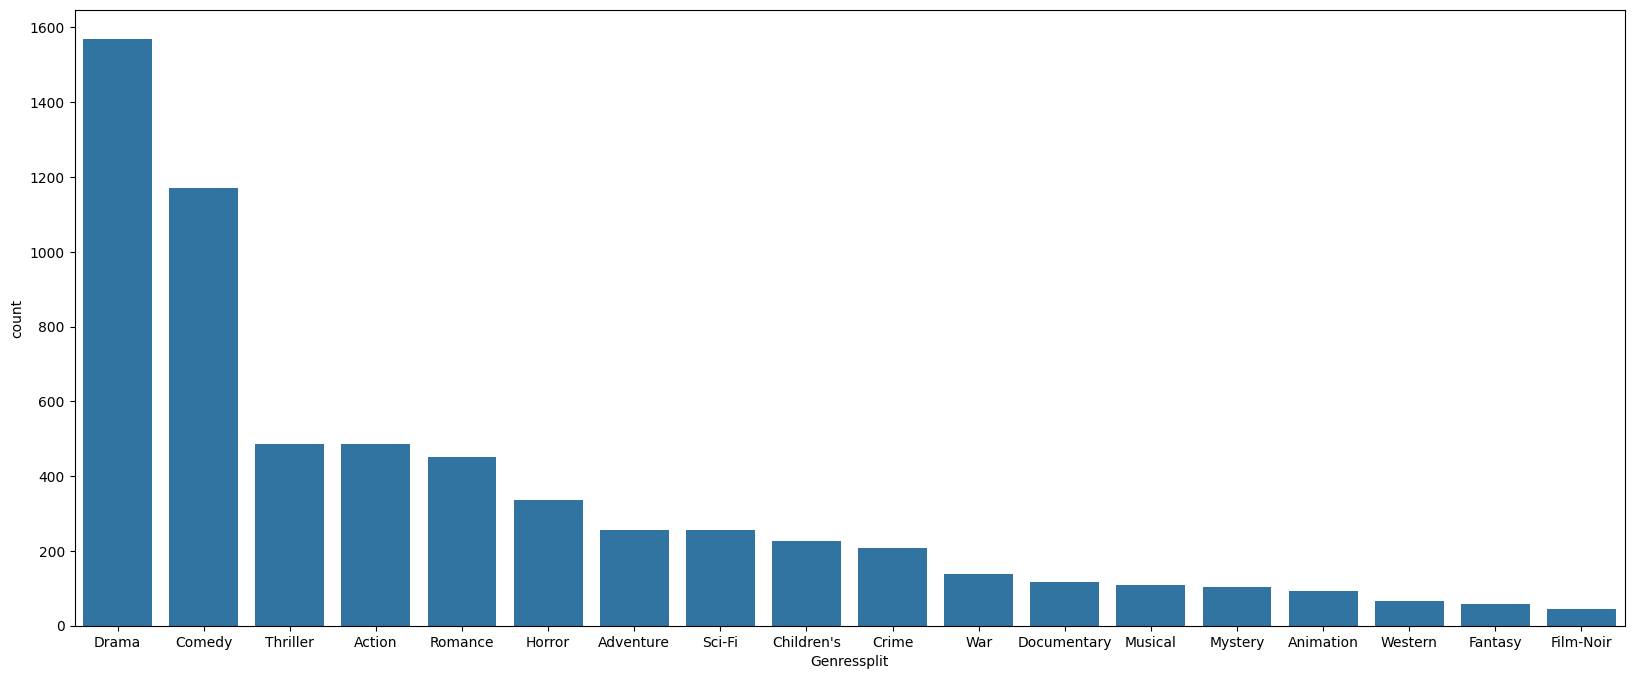

In [64]:
plt.figure(figsize =(20,8))
sns.countplot(data= movies, x="Genressplit", order = movies["Genressplit"].value_counts().reset_index()["index"])

In [65]:
movies.Releaseyear.describe()

count    6174.000000
mean     1986.229997
std        16.547598
min      1919.000000
25%      1983.000000
50%      1994.000000
75%      1997.000000
max      2000.000000
Name: Releaseyear, dtype: float64

<Axes: xlabel='Releaseyear', ylabel='Count'>

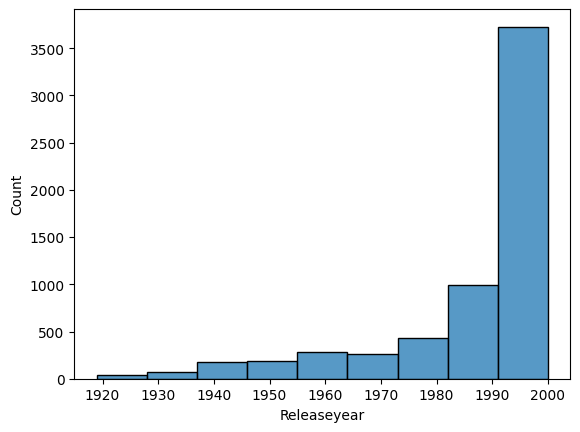

In [66]:
sns.histplot(data=movies, x= "Releaseyear", bins =9)

* lets Convert Release year into bins as Release year recency factor

In [67]:
bins = [1919,1940,1960,1980,1990,2000]
movies["Releaseyeargroups"] = pd.cut(movies["Releaseyear"], bins, labels=[1,2,3,4,5])

<Axes: xlabel='count', ylabel='Releaseyeargroups'>

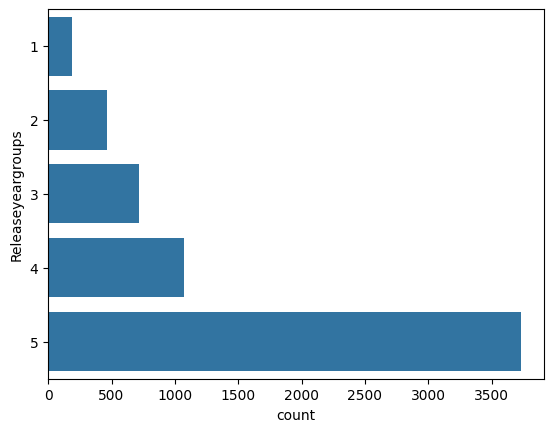

In [68]:
sns.countplot( movies["Releaseyeargroups"])

In [69]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3783
No of Unique Genres are 296
No of Unique Genressplit are 18
No of Unique Releaseyear are 81
No of Unique Releaseyeargroups are 5


## Users

In [70]:
for i in users.columns:
  print("No of Unique {} are {}".format(i,users[i].nunique()))

No of Unique USerID are 6040
No of Unique Gender are 2
No of Unique Age are 7
No of Unique Occupation are 21
No of Unique Zipcode are 3439


In [71]:
users.shape

(6040, 5)

In [72]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [73]:
Occup = {0: "other",
1: "academic/educator",
2: "artist",
3: "clerical/admin",
4: "college/grad student",
5: "customer service",
6: "doctor/health care",
7: "executive/managerial",
8: "farmer",
9: "homemaker",
10: "K-12 student",
11: "lawyer",
12: "programmer",
13: "retired",
14: "sales/marketing",
15: "scientist",
16: "self-employed",
17: "technician/engineer",
18: "tradesman/craftsman",
19: "unemployed",
20: "writer"}

In [74]:
users["Occupation"].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: Occupation, dtype: int64

<Axes: xlabel='index', ylabel='Occupation'>

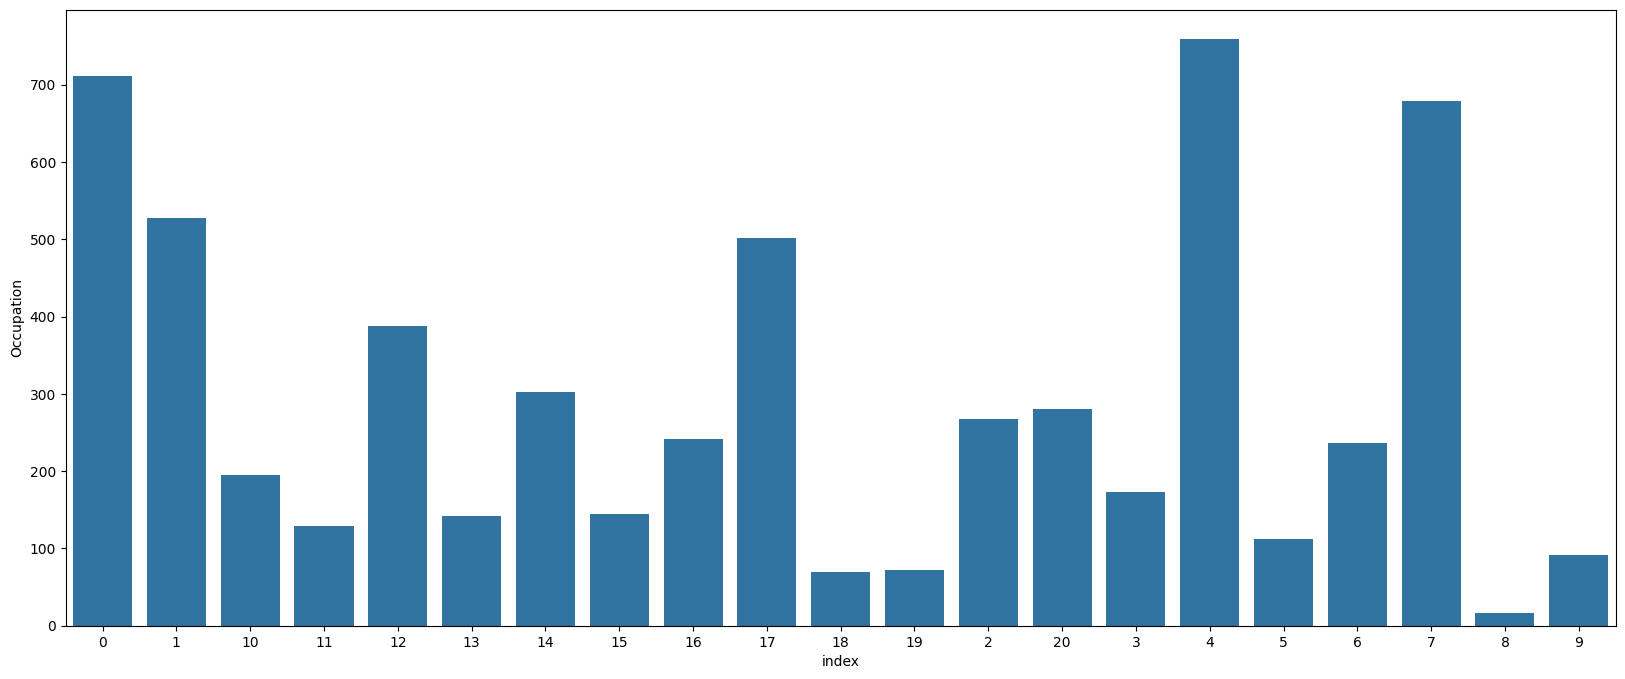

In [75]:
plt.figure(figsize =(20,8))
sns.barplot(data= users["Occupation"].value_counts().reset_index(), x= "index", y="Occupation")

In [76]:
users["Age"].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: Age, dtype: int64

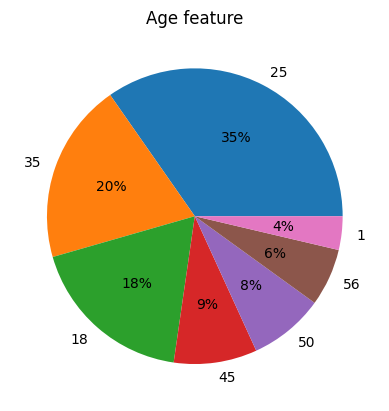

In [77]:
plt.pie(x = users["Age"].value_counts().reset_index()["Age"],
        labels = users["Age"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Age feature")
plt.show()

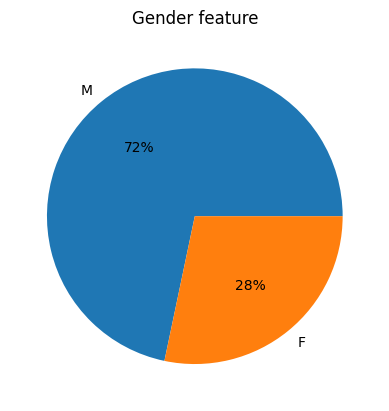

In [78]:
plt.pie(x = users["Gender"].value_counts().reset_index()["Gender"],
        labels = users["Gender"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Gender feature")
plt.show()

In [79]:
users["Zipcode"].value_counts().head(5)

48104    19
22903    18
94110    17
55104    17
10025    16
Name: Zipcode, dtype: int64

In [80]:
users["Zipcode"].value_counts().tail(5)

37843    1
37877    1
37909    1
37914    1
99945    1
Name: Zipcode, dtype: int64

## Ratings

In [81]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


In [82]:
for i in ratings.columns:
  print("No of Unique {} are {}".format(i,ratings[i].nunique()))

No of Unique USerID are 6040
No of Unique Movie ID are 3706
No of Unique Rating are 5
No of Unique Timestamp are 458455
No of Unique hour are 24
No of Unique dayofweek are 7
No of Unique month are 12
No of Unique year are 4
No of Unique day are 31


In [83]:
ratings.shape

(1000209, 9)

In [84]:
ratings["Rating"].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

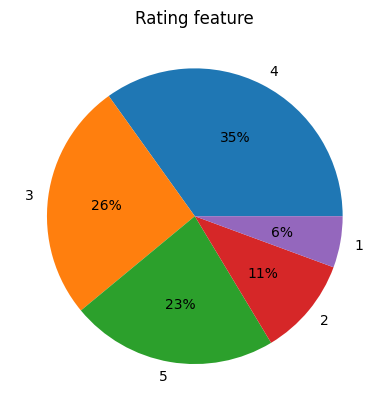

In [85]:
plt.pie(x = ratings["Rating"].value_counts().reset_index()["Rating"],
        labels = ratings["Rating"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Rating feature")
plt.show()

<Axes: xlabel='hour', ylabel='count'>

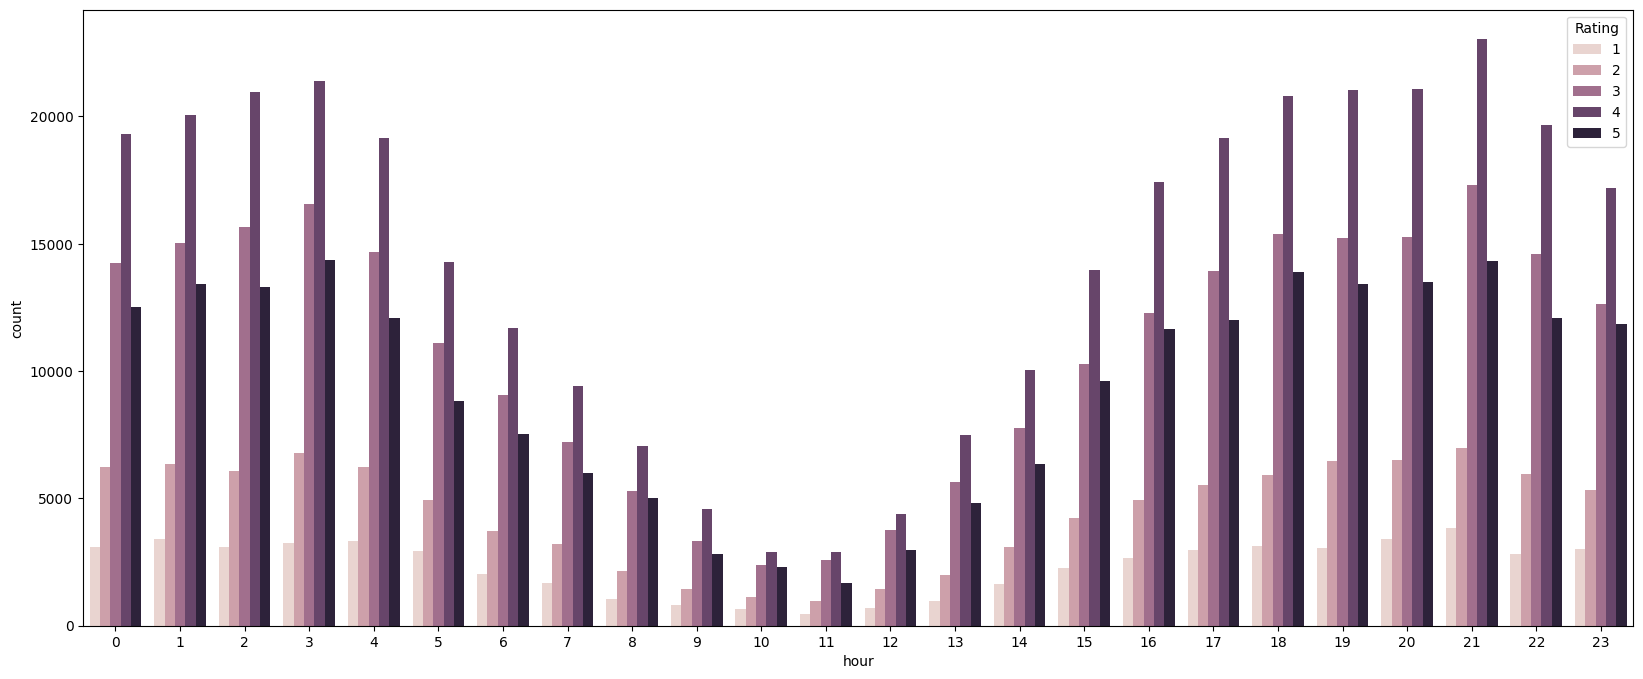

In [86]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "hour",hue = "Rating")

<Axes: xlabel='dayofweek', ylabel='count'>

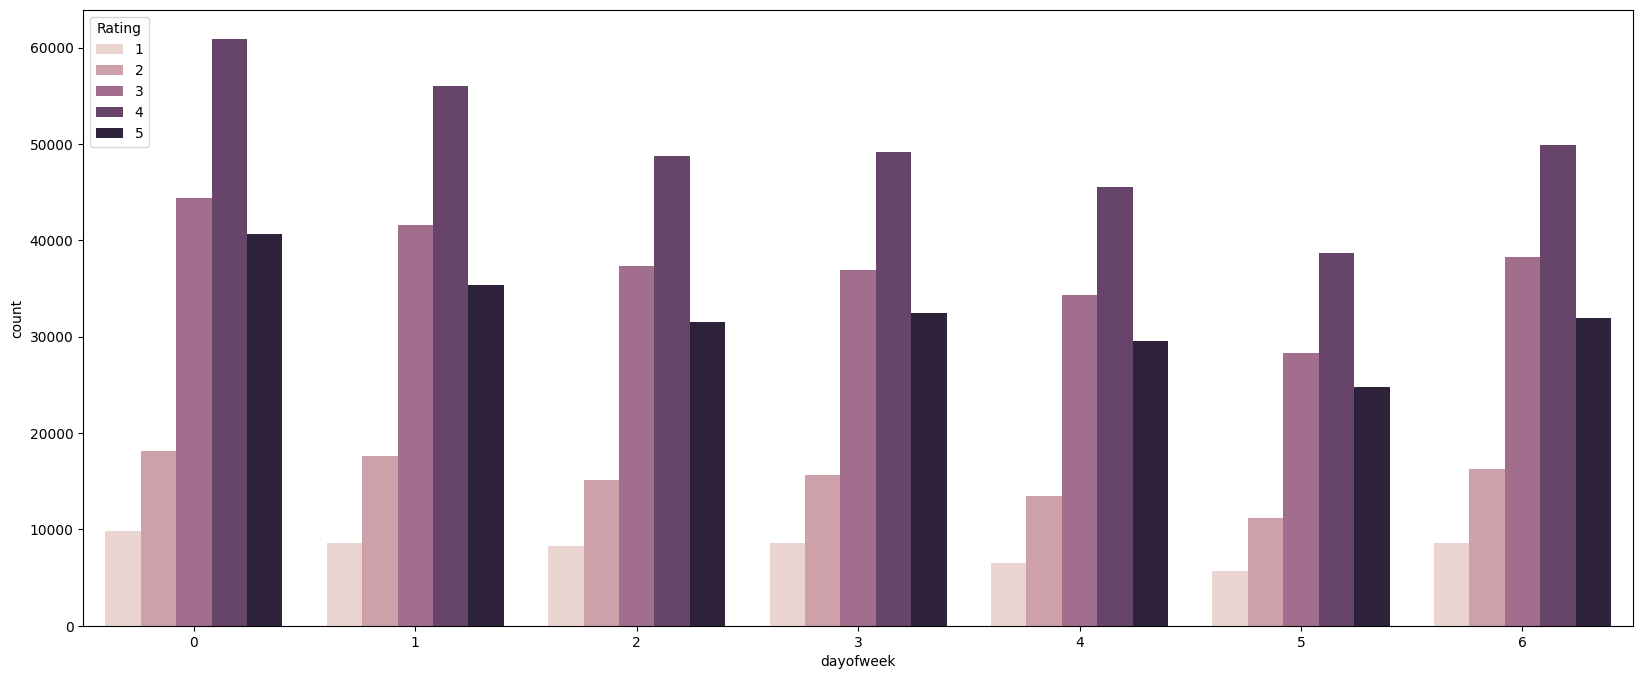

In [87]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "dayofweek",hue = "Rating")

<Axes: xlabel='month', ylabel='count'>

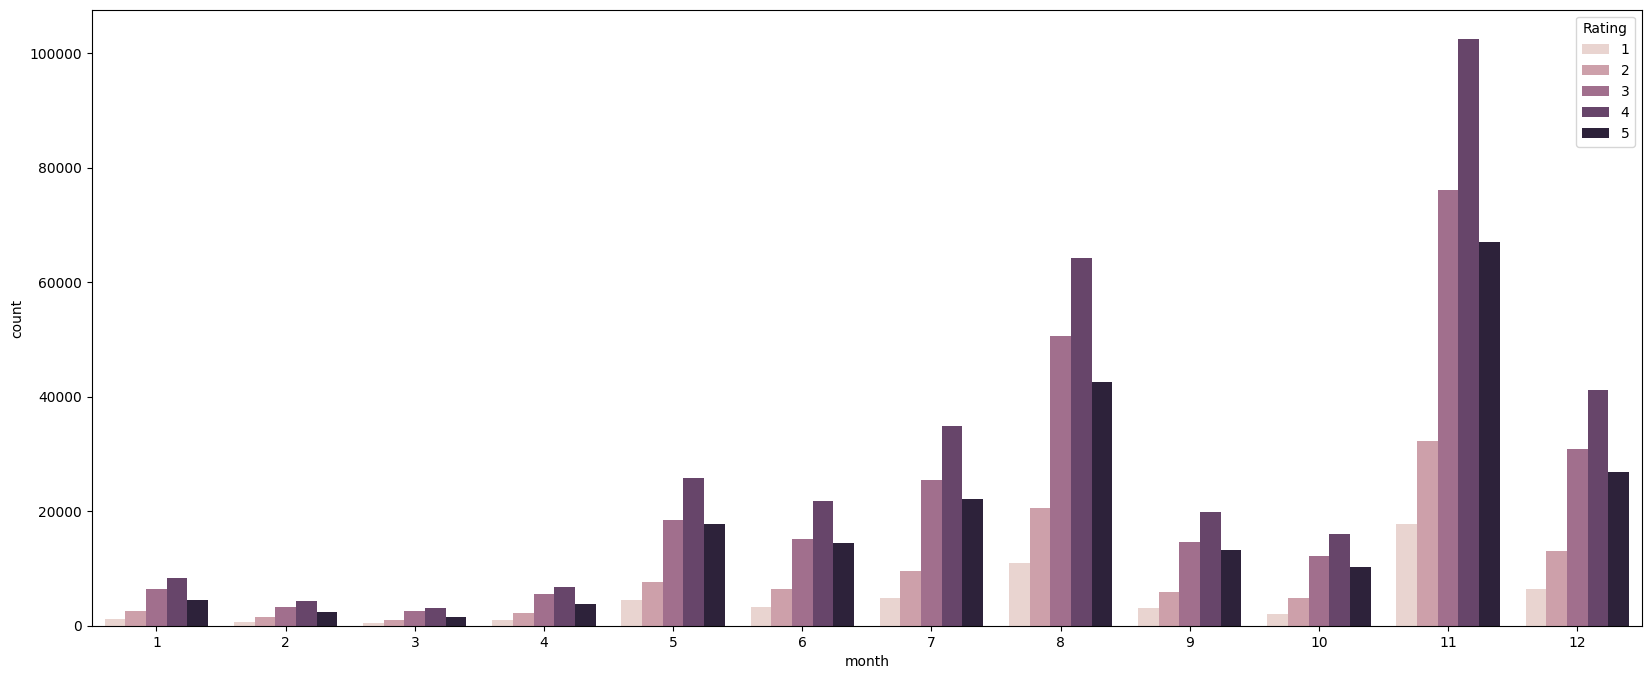

In [88]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "month",hue = "Rating")

<Axes: xlabel='year', ylabel='count'>

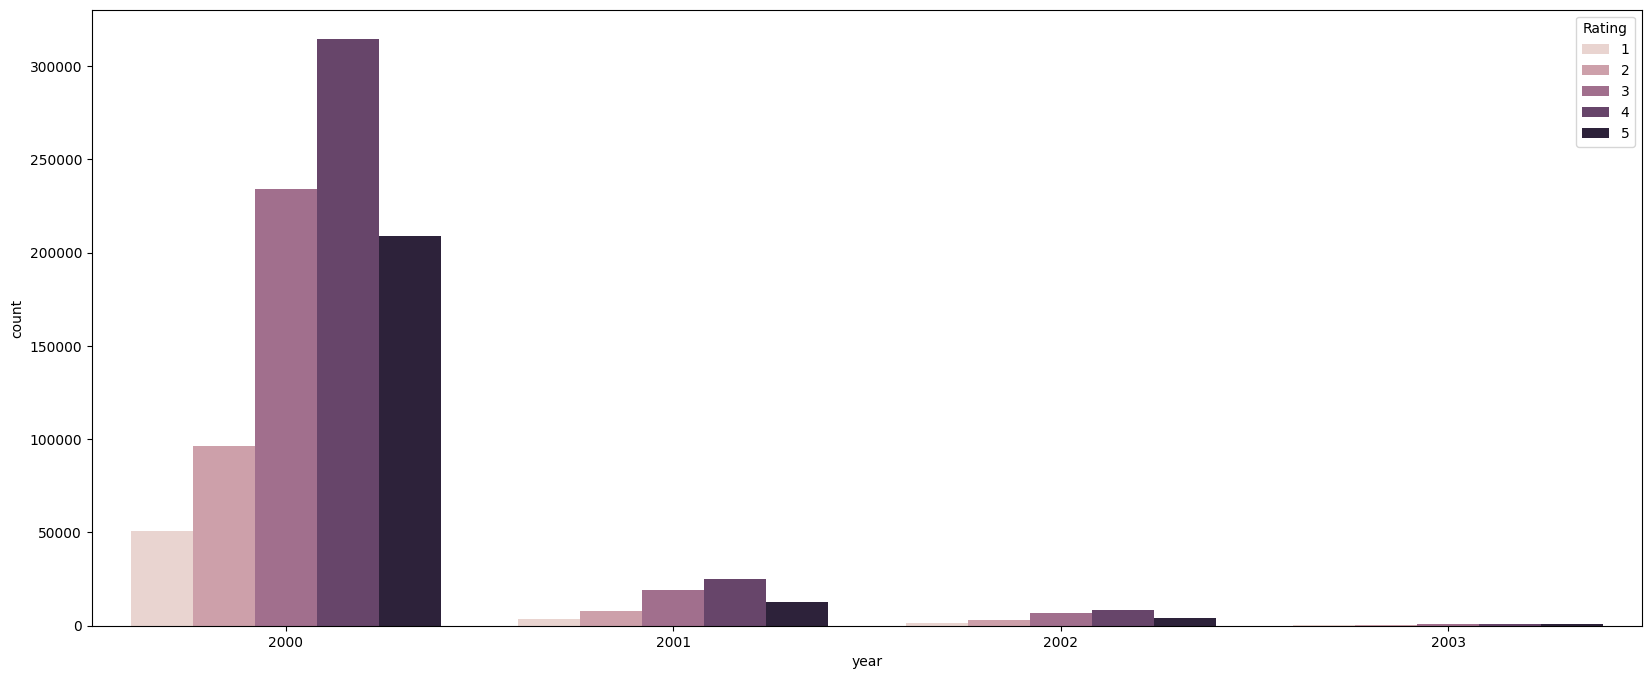

In [89]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "year",hue = "Rating")

In [90]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

# Creating Matrices

## Selecting 1000 Most Rated Movies & 1000 Most Watched users

In [91]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6174 entries, 0 to 3882
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Movie ID           6174 non-null   object  
 1   Title              6174 non-null   object  
 2   Genres             6174 non-null   category
 3   Genressplit        6174 non-null   object  
 4   Releaseyear        6174 non-null   int64   
 5   Releaseyeargroups  6171 non-null   category
dtypes: category(2), int64(1), object(3)
memory usage: 269.9+ KB


In [92]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [93]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [94]:
select_movies = ratings['Movie ID'].value_counts()[:1000].index.to_list()

In [102]:
movies = movies.loc[movies["Movie ID"].isin(select_movies)]
movies.shape

(2024, 6)

In [103]:
select_users = ratings['USerID'].value_counts()[:1000].index.to_list()

In [104]:
users = users.loc[users["USerID"].isin(select_users)]
users.shape

(1000, 5)

In [155]:
ratings = ratings.loc[ratings["Movie ID"].isin(select_movies)]
ratings = ratings.loc[ratings["Movie ID"].isin(select_users)]

In [156]:
ratings.shape

(104010, 9)

## Combination 3 Data frames

In [105]:
data = ratings.merge(users[["USerID","Gender","Age","Occupation"]],on = "USerID", how = "right")

In [106]:
data = data.merge(movies[["Movie ID","Genres","Releaseyeargroups","Releaseyear"]],on = "Movie ID", how = 'right')

In [108]:
data.shape

(751539, 15)

In [107]:
data.head(10)

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day,Gender,Age,Occupation,Genres,Releaseyeargroups,Releaseyear
0,10,1,5,978226474,1,6,12,2000,31,F,35,1,Animation|Children's|Comedy,5,1995
1,18,1,4,978154768,5,5,12,2000,30,F,18,3,Animation|Children's|Comedy,5,1995
2,23,1,4,978463614,19,1,1,2001,2,M,35,0,Animation|Children's|Comedy,5,1995
3,26,1,3,978130703,22,4,12,2000,29,M,25,7,Animation|Children's|Comedy,5,1995
4,36,1,5,978061285,3,4,12,2000,29,M,25,3,Animation|Children's|Comedy,5,1995
5,45,1,4,977990044,7,3,12,2000,28,F,45,16,Animation|Children's|Comedy,5,1995
6,48,1,4,977975909,3,3,12,2000,28,M,25,4,Animation|Children's|Comedy,5,1995
7,92,1,4,977646817,8,6,12,2000,24,F,18,4,Animation|Children's|Comedy,5,1995
8,117,1,3,977498304,15,4,12,2000,22,M,25,17,Animation|Children's|Comedy,5,1995
9,123,1,3,978046755,23,3,12,2000,28,M,35,9,Animation|Children's|Comedy,5,1995


* Now we have all the required information in one Dataframe, from this Dataframe we can extract specifica information for User-User and Item-Item Based Recommendation Approach

## Item-Item Approach

Lets Create a Matrix for Item[Movie]

In [109]:
movies.columns

Index(['Movie ID', 'Title', 'Genres', 'Genressplit', 'Releaseyear',
       'Releaseyeargroups'],
      dtype='object')

In [110]:
item_item = movies[['Movie ID','Releaseyear']].drop_duplicates()

In [111]:
item_item.head()

,Movie ID,Releaseyear
0,1,1995
1,2,1995
2,3,1995
5,6,1995
6,7,1995


In [112]:
item_item.shape

(976, 2)

### Adding Average Rating of an Item

In [113]:
item_item = item_item.merge(data.groupby('Movie ID').Rating.mean().reset_index(), on='Movie ID', how = "left")

In [114]:
item_item.head()

,Movie ID,Releaseyear,Rating
0,1,1995,4.118598
1,2,1995,3.144279
2,3,1995,2.874510
3,6,1995,3.836601
4,7,1995,3.231579


### Adding Genre By doing sort of OHE

In [115]:
m = movies.pivot(index='Movie ID', columns='Genressplit', values='Title')
m = ~m.isna()
m = m.astype(int)

In [116]:
m.head()

Genressplit,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Movie ID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1020,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1022,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1027,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [117]:
item_item = item_item.merge(m, on='Movie ID', how = "left")

### Adding Gender wise Ratings for an item

In [118]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Gender'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Gender', values='Rating').
    reset_index(), on='Movie ID', how = "left")

In [119]:
item_item.head()

,Movie ID,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,F,M
0,1,1995,4.118598,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.105263,4.122592
1,2,1995,3.144279,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.247059,3.116719
2,3,1995,2.874510,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2.754098,2.912371
3,6,1995,3.836601,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,3.546667,3.893229
4,7,1995,3.231579,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.366972,3.147727


In [120]:
data.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Genres',
       'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

### Adding Age wise Ratings for an item

In [121]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Age'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Age', values='Rating').
    reset_index(), on='Movie ID', how = "left")

### Adding Occupation wise Ratings for an item

In [122]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Occupation'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Occupation', values='Rating').
    reset_index(), on='Movie ID', how = "left")

In [123]:
item_item.shape

(976, 51)

### Final item_item Matrix

In [124]:
item_item.shape

(976, 51)

In [125]:
item_item.columns

Index(['Movie ID', 'Releaseyear', 'Rating', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'F', 'M', '1_x', '18_x', '25', '35', '45',
       '50', '56', '0', '1_y', '10', '11', '12', '13', '14', '15', '16', '17',
       '18_y', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [126]:
item_item =item_item.set_index("Movie ID")

In [127]:
item_item.fillna(0, inplace=True)

In [128]:
item_item.head(10)

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,1995,4.118598,0,0,1,1,1,0,0,0,...,3.833333,4.000000,4.080000,4.481481,3.949495,4.142857,4.413793,4.222222,5.0,3.666667
2,1995,3.144279,0,1,0,1,0,0,0,0,...,2.833333,2.578947,3.000000,3.428571,3.087719,3.272727,3.352941,3.170732,4.0,3.400000
3,1995,2.874510,0,0,0,0,1,0,0,0,...,3.000000,2.272727,2.571429,2.727273,2.885714,2.600000,2.300000,2.777778,3.0,2.333333
6,1995,3.836601,1,0,0,0,0,1,0,0,...,4.000000,3.760000,3.466667,3.625000,3.916667,3.727273,4.250000,3.854167,4.0,4.333333
7,1995,3.231579,0,0,0,0,1,0,0,0,...,3.000000,2.941176,3.000000,2.750000,3.394737,3.200000,3.333333,3.088235,3.0,4.000000
10,1995,3.445396,1,1,0,0,0,0,0,0,...,2.833333,3.500000,3.115385,3.642857,3.623188,3.083333,3.666667,3.607843,3.0,3.200000
11,1995,3.661943,0,0,0,0,1,0,0,1,...,3.500000,3.333333,3.074074,3.437500,3.771429,4.111111,3.846154,3.666667,4.0,4.000000
16,1995,3.805970,0,0,0,0,0,0,0,1,...,3.000000,3.588235,3.550000,3.461538,4.019231,3.900000,4.230769,3.938776,3.0,3.500000
17,1995,3.955090,0,0,0,0,0,0,0,1,...,4.000000,3.923077,3.852941,3.666667,3.909091,3.666667,4.277778,3.941176,5.0,4.166667


In [129]:
scaler = MinMaxScaler()
item_item_scaled = pd.DataFrame(scaler.fit_transform(item_item), columns=item_item.columns, index=item_item.index)
item_item_scaled.head()

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,0.932432,0.839631,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.766667,0.776119,0.847000,0.861728,0.775395,0.828571,0.877833,0.833112,1.0,0.733333
2,0.932432,0.518590,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.566667,0.362529,0.550000,0.580952,0.511573,0.654545,0.605042,0.494968,0.8,0.680000
3,0.932432,0.429700,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.600000,0.273406,0.432143,0.393939,0.449731,0.520000,0.334286,0.368600,0.6,0.466667
6,0.932432,0.746712,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.800000,0.706269,0.678333,0.633333,0.765345,0.745455,0.835714,0.714751,0.8,0.866667
7,0.932432,0.547355,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.600000,0.467954,0.550000,0.400000,0.605562,0.640000,0.600000,0.468439,0.6,0.800000


In [130]:
item_item_scaled.describe()

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
count,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,...,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000
mean,0.820586,0.649157,0.258197,0.120902,0.047131,0.065574,0.360656,0.081967,0.003074,0.345287,...,0.693223,0.608559,0.666586,0.633772,0.652880,0.720561,0.685071,0.611456,0.558094,0.675603
std,0.190585,0.164862,0.437867,0.326180,0.212028,0.247662,0.480437,0.274455,0.055385,0.475705,...,0.152668,0.175338,0.162714,0.156204,0.167532,0.119536,0.143099,0.167957,0.361955,0.208961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.756757,0.541569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.600000,0.485075,0.550000,0.546667,0.538209,0.660000,0.600000,0.505477,0.200000,0.600000
50%,0.891892,0.670116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.700000,0.630597,0.687500,0.644444,0.673967,0.727922,0.707143,0.634895,0.600000,0.720000
75%,0.959459,0.772442,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.800000,0.734542,0.783750,0.733333,0.775004,0.800000,0.789796,0.734276,0.800000,0.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## User-User Approach

* Lets Create a Matric for User

In [131]:
users.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode'], dtype='object')

In [132]:
user_user = users[['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode']].drop_duplicates()

In [133]:
user_user.head()

,USerID,Gender,Age,Occupation,Zipcode
9,10,F,35,1,95370
17,18,F,18,3,95825
21,22,M,18,15,53706
22,23,M,35,0,90049
25,26,M,25,7,23112


### Adding Average Rating of a User

In [134]:
user_user = user_user.merge(data.groupby('USerID').Rating.mean().reset_index(), on='USerID', how = "left")

### Adding count of Movies rated by a user

In [135]:
user_user = user_user.merge(data.groupby('USerID').Rating.count().reset_index(), on='USerID', how = "left")

In [136]:
user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Rating_x',
       'Rating_y'],
      dtype='object')

In [137]:
user_user.rename(columns = {'Rating_x':'Ave.rating','Rating_y':'movie_count'}, inplace = True)

In [138]:
user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Ave.rating',
       'movie_count'],
      dtype='object')

### Adding Average Hour, weekday, day,month for rating for a user

In [139]:
data.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Genres',
       'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

In [140]:
user_user = user_user.merge(data.groupby('USerID').hour.mean().reset_index(), on='USerID', how = "left")
user_user = user_user.merge(data.groupby('USerID').dayofweek.mean().reset_index(), on='USerID', how = "left")
user_user = user_user.merge(data.groupby('USerID').day.mean().reset_index(), on='USerID', how = "left")
user_user = user_user.merge(data.groupby('USerID').month.mean().reset_index(), on='USerID', how = "left")

### Label Encoding Gender

In [141]:
le=LabelEncoder()
user_user["Gender"]=le.fit_transform(user_user["Gender"])
user_user["Gender"].value_counts()

1    769
0    231
Name: Gender, dtype: int64

### Target Encoding Occupation and ZipCode

In [142]:
te=TargetEncoder()
user_user["Occupation"]=te.fit_transform(user_user["Occupation"],user_user["Ave.rating"])
user_user["Zipcode"]=te.fit_transform(user_user["Zipcode"],user_user["Ave.rating"])

In [143]:
user_user.head()

,USerID,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count,hour,dayofweek,day,month
0,10,0,35,3.515322,3.664194,4.175595,672,7.467262,4.901786,25.660714,8.824405
1,18,0,18,3.654193,3.599870,3.681208,596,5.127517,5.000000,30.000000,12.000000
2,22,1,18,3.640744,3.562083,3.043956,546,3.694139,4.864469,28.234432,10.269231
3,23,1,35,3.556170,3.563369,3.400668,599,17.934891,1.190317,4.313856,1.522538
4,26,1,25,3.623283,3.515404,3.032015,531,5.617702,5.160075,29.888889,11.875706


### Final user_user Matrix

In [144]:
user_user.shape

(1000, 11)

In [145]:
user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Ave.rating',
       'movie_count', 'hour', 'dayofweek', 'day', 'month'],
      dtype='object')

In [146]:
user_user =user_user.set_index("USerID")

In [147]:
item_item.fillna(0, inplace=True)

In [148]:
scaler1 = MinMaxScaler()
user_user_scaled = pd.DataFrame(scaler1.fit_transform(user_user), columns=user_user.columns, index=user_user.index)
user_user_scaled.head()

,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count,hour,dayofweek,day,month
USerID,,,,,,,,,,
10,0.0,0.618182,0.000000,0.788443,0.792383,0.275701,0.324758,0.816964,0.822024,0.696912
18,0.0,0.309091,0.712702,0.583916,0.591665,0.224967,0.221804,0.833333,0.966667,1.000000
22,1.0,0.309091,0.643679,0.463769,0.332945,0.191589,0.158732,0.810745,0.907814,0.834810
23,1.0,0.618182,0.209636,0.467857,0.477768,0.226969,0.785358,0.198386,0.110462,0.000000
26,1.0,0.436364,0.554071,0.315346,0.328097,0.181575,0.243374,0.860013,0.962963,0.988137


In [149]:
user_user_scaled.describe()

,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count,hour,dayofweek,day,month
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.769000,0.510291,0.358780,0.544965,0.553703,0.328798,0.512404,0.472405,0.483055,0.679194
std,0.421683,0.192363,0.236672,0.154116,0.161523,0.172675,0.265990,0.276812,0.250430,0.206929
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.436364,0.209636,0.452679,0.461019,0.202937,0.269487,0.260886,0.273486,0.523728
50%,1.000000,0.436364,0.245048,0.551051,0.559761,0.291389,0.532134,0.462721,0.514520,0.642360
75%,1.000000,0.618182,0.554071,0.655041,0.664233,0.428571,0.750270,0.666667,0.663106,0.898473
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## User_Item Intraction Matrix

In [157]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

In [158]:
user_item = ratings.pivot(index = 'USerID',columns ='Movie ID',values = 'Rating' )

In [159]:
user_item.fillna(0,inplace = True)

In [160]:
user_item.shape

(5915, 160)

In [154]:
user_item.head()

Movie ID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
USerID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Pearson Correltion for Item Item Recommendation

In [161]:
item_item_scaled.shape

(976, 50)

In [162]:
item_item_scaled.index

Index(['1', '2', '3', '6', '7', '10', '11', '16', '17', '19',
       ...
       '3863', '3868', '3869', '3893', '3897', '3911', '3916', '3927', '3948',
       '3952'],
      dtype='object', name='Movie ID', length=976)

* Creating a DataFrame for a Query and All Candidates with Peason Correlation

In [165]:
ranks = []

for query in item_item_scaled.index:
    for candidate in item_item_scaled.index:
        if candidate == query:
            continue
        ranks.append([query, candidate, pearsonr(item_item_scaled.loc[query], item_item_scaled.loc[candidate])[0]])


Pearson_Item_df = pd.DataFrame(ranks, columns=['query', 'candidate', 'Pearson'])
Pearson_Item_df.head()

,query,candidate,Pearson
0,1,2,0.604590
1,1,3,0.664959
2,1,6,0.559148
3,1,7,0.719536
4,1,10,0.482636


In [166]:
movies.columns

Index(['Movie ID', 'Title', 'Genres', 'Genressplit', 'Releaseyear',
       'Releaseyeargroups'],
      dtype='object')

In [168]:
Pearson_Item_df = Pearson_Item_df.merge(movies[['Movie ID', 'Title']], left_on='query', right_on='Movie ID').rename(columns={'Title': 'query_title'}).drop(columns=['Movie ID'])
Pearson_Item_df = Pearson_Item_df.merge(movies[['Movie ID', 'Title']], left_on='candidate', right_on='Movie ID').rename(columns={'Title': 'Rec_candidate_title'}).drop(columns=['Movie ID'])
Pearson_Item_df = Pearson_Item_df.sort_values(by=['query', 'Pearson'], ascending = [True, False])
Pearson_Item_df.drop_duplicates(inplace=True)
Pearson_Item_df.head()

,query,candidate,Pearson,query_title,Rec_candidate_title,query_title,Rec_candidate_title
11253762,1,1556,-0.026221,Toy Story (1995),Speed 2: Cruise Control (1997),Toy Story (1995),Speed 2: Cruise Control (1997)
11253763,1,1556,-0.026221,Toy Story (1995),Speed 2: Cruise Control (1997),Toy Story (1995),Speed 2: Cruise Control (1997)
11253764,1,1556,-0.026221,Toy Story (1995),Speed 2: Cruise Control (1997),Toy Story (1995),Speed 2: Cruise Control (1997)
11253765,1,1556,-0.026221,Toy Story (1995),Speed 2: Cruise Control (1997),Toy Story (1995),Speed 2: Cruise Control (1997)
11253766,1,1556,-0.026221,Toy Story (1995),Speed 2: Cruise Control (1997),Toy Story (1995),Speed 2: Cruise Control (1997)


In [169]:
Pearson_Item_df.drop_duplicates(inplace=True)

In [170]:
Pearson_Item_df.shape

(951600, 7)

In [172]:
Pearson_Item_df = Pearson_Item_df.sort_values(by=['query', 'Pearson'], ascending = [True, False])

In [173]:
Pearson_Item_df.head()

,query,candidate,Pearson,query_title,Rec_candidate_title,query_title,Rec_candidate_title
21581565,1,3114,0.991886,Toy Story (1995),Toy Story 2 (1999),Toy Story (1995),Toy Story 2 (1999)
17225874,1,2355,0.991738,Toy Story (1995),"Bug's Life, A (1998)",Toy Story (1995),"Bug's Life, A (1998)"
24529281,1,3751,0.983111,Toy Story (1995),Chicken Run (2000),Toy Story (1995),Chicken Run (2000)
8552205,1,1223,0.923581,Toy Story (1995),"Grand Day Out, A (1992)",Toy Story (1995),"Grand Day Out, A (1992)"
7655688,1,1148,0.923447,Toy Story (1995),"Wrong Trousers, The (1993)",Toy Story (1995),"Wrong Trousers, The (1993)"


## Function for Item-Item Recommendation using Pearson Correaltion Coefficient

In [194]:
# This function work only if we precalculate all possible pearson correlation values for Item vs Item
# But this is efficient as we have to calcuate Pearson Correlation values only once
# and we can query through below function multiple time

def Item_Rec(data,Movie_ID,k):
  # Data is pearson Correlation Dataframe for all item vs item
  # Movie_ID --> Item for which we are finding simialar movies
  # k --> No of Recommenadions Required
  return (data.loc[data["query"] == Movie_ID])[:k]

In [243]:
Item_Rec(data = Pearson_Item_df ,Movie_ID = "1",k=5)

,query,candidate,Pearson,query_title,Rec_candidate_title,query_title,Rec_candidate_title
21581565,1,3114,0.991886,Toy Story (1995),Toy Story 2 (1999),Toy Story (1995),Toy Story 2 (1999)
17225874,1,2355,0.991738,Toy Story (1995),"Bug's Life, A (1998)",Toy Story (1995),"Bug's Life, A (1998)"
24529281,1,3751,0.983111,Toy Story (1995),Chicken Run (2000),Toy Story (1995),Chicken Run (2000)
8552205,1,1223,0.923581,Toy Story (1995),"Grand Day Out, A (1992)",Toy Story (1995),"Grand Day Out, A (1992)"
7655688,1,1148,0.923447,Toy Story (1995),"Wrong Trousers, The (1993)",Toy Story (1995),"Wrong Trousers, The (1993)"


# Cosine Simialrity Matrix for items

In [197]:
Cosine_Item_Matrix= cosine_similarity(item_item_scaled)

In [198]:
Cosine_Item_Matrix.shape

(976, 976)

In [199]:
Cosine_Item_Matrix

array([[1.        , 0.87006646, 0.88116146, ..., 0.84282108, 0.90654986,
        0.82580961],
       [0.87006646, 1.        , 0.77969586, ..., 0.84228991, 0.82098621,
        0.77555389],
       [0.88116146, 0.77969586, 1.        , ..., 0.7742923 , 0.88098996,
        0.76826642],
       ...,
       [0.84282108, 0.84228991, 0.7742923 , ..., 1.        , 0.83453074,
        0.82651856],
       [0.90654986, 0.82098621, 0.88098996, ..., 0.83453074, 1.        ,
        0.88169918],
       [0.82580961, 0.77555389, 0.76826642, ..., 0.82651856, 0.88169918,
        1.        ]])

In [201]:
Cosine_Item_Mat_df = pd.DataFrame(Cosine_Item_Matrix, index = item_item_scaled.index, columns = item_item_scaled.index )

In [202]:
Cosine_Item_Mat_df

Movie ID,1,2,3,6,7,10,11,16,17,19,...,3863,3868,3869,3893,3897,3911,3916,3927,3948,3952
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.870066,0.881161,0.863783,0.905579,0.836112,0.902030,0.856726,0.876303,0.844698,...,0.825611,0.951386,0.937018,0.894715,0.936804,0.953418,0.860025,0.842821,0.906550,0.825810
2,0.870066,1.000000,0.779696,0.805213,0.805253,0.857140,0.806551,0.816625,0.818021,0.734305,...,0.796189,0.848157,0.836826,0.793096,0.834635,0.849304,0.820522,0.842290,0.820986,0.775554
3,0.881161,0.779696,1.000000,0.813927,0.983843,0.790526,0.949329,0.796574,0.882326,0.880996,...,0.771802,0.924591,0.938131,0.877770,0.898160,0.922586,0.800100,0.774292,0.880990,0.768266
6,0.863783,0.805213,0.813927,1.000000,0.844156,0.936083,0.846084,0.898857,0.865581,0.756206,...,0.871590,0.894587,0.869301,0.892155,0.884865,0.897956,0.850961,0.824869,0.846936,0.862837
7,0.905579,0.805253,0.983843,0.844156,1.000000,0.820446,0.962502,0.836780,0.909549,0.872103,...,0.806187,0.948002,0.949328,0.906529,0.924366,0.944451,0.835908,0.802116,0.910420,0.794295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,0.953418,0.849304,0.922586,0.897956,0.944451,0.867288,0.939398,0.889948,0.910967,0.896029,...,0.848359,0.990592,0.980210,0.929954,0.972405,1.000000,0.885320,0.867956,0.939537,0.853665
3916,0.860025,0.820522,0.800100,0.850961,0.835908,0.843586,0.906543,0.947713,0.906447,0.734827,...,0.839612,0.890384,0.849674,0.876370,0.939827,0.885320,1.000000,0.836448,0.928057,0.944069
3927,0.842821,0.842290,0.774292,0.824869,0.802116,0.866246,0.812453,0.829250,0.864123,0.712889,...,0.856874,0.869017,0.827917,0.813153,0.860942,0.867956,0.836448,1.000000,0.834531,0.826519


# Cosine Similarity Matrix for Users

In [204]:
Cosine_User_Matrix= cosine_similarity(user_user_scaled)

In [205]:
Cosine_User_Matrix.shape

(1000, 1000)

In [206]:
Cosine_User_Matrix

array([[1.        , 0.89519699, 0.75665161, ..., 0.71989674, 0.81829577,
        0.65972244],
       [0.89519699, 1.        , 0.86142648, ..., 0.60438336, 0.87533041,
        0.75412339],
       [0.75665161, 0.86142648, 1.        , ..., 0.76970319, 0.75548841,
        0.89926712],
       ...,
       [0.71989674, 0.60438336, 0.76970319, ..., 1.        , 0.70726427,
        0.79418284],
       [0.81829577, 0.87533041, 0.75548841, ..., 0.70726427, 1.        ,
        0.78261326],
       [0.65972244, 0.75412339, 0.89926712, ..., 0.79418284, 0.78261326,
        1.        ]])

In [207]:
Cosine_User_Mat_df = pd.DataFrame(Cosine_User_Matrix, index = user_user_scaled.index, columns = user_user_scaled.index )

In [208]:
Cosine_User_Mat_df

USerID,10,18,22,23,26,33,36,45,48,53,...,5972,5978,5996,6000,6002,6007,6010,6016,6036,6040
USerID,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.895197,0.756652,0.553219,0.768487,0.728542,0.834231,0.901144,0.792549,0.852962,...,0.902982,0.783239,0.888107,0.753340,0.816872,0.664578,0.793259,0.719897,0.818296,0.659722
18,0.895197,1.000000,0.861426,0.431495,0.860889,0.739296,0.881037,0.932471,0.820832,0.824501,...,0.786923,0.692386,0.795704,0.757997,0.715574,0.673205,0.695773,0.604383,0.875330,0.754123
22,0.756652,0.861426,1.000000,0.655572,0.991216,0.870173,0.961088,0.808064,0.953526,0.909001,...,0.647162,0.876034,0.660005,0.914364,0.850119,0.826797,0.832848,0.769703,0.755488,0.899267
23,0.553219,0.431495,0.655572,1.000000,0.648226,0.904932,0.753381,0.494801,0.694357,0.742662,...,0.700219,0.869431,0.692031,0.808331,0.821118,0.897099,0.922009,0.891348,0.539521,0.827917
26,0.768487,0.860889,0.991216,0.648226,1.000000,0.868386,0.945340,0.836442,0.967750,0.904870,...,0.658124,0.892831,0.661697,0.901965,0.842812,0.826085,0.825871,0.789353,0.737641,0.868976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,0.664578,0.673205,0.826797,0.897099,0.826085,0.966766,0.872295,0.707559,0.829235,0.820005,...,0.771775,0.906207,0.796251,0.909949,0.789386,1.000000,0.943428,0.924932,0.752875,0.931418
6010,0.793259,0.695773,0.832848,0.922009,0.825871,0.947242,0.911460,0.720502,0.856693,0.904323,...,0.840428,0.959548,0.841199,0.917993,0.910751,0.943428,1.000000,0.938525,0.734133,0.895360
6016,0.719897,0.604383,0.769703,0.891348,0.789353,0.896161,0.814121,0.681494,0.863014,0.847061,...,0.782614,0.957173,0.808057,0.882029,0.817658,0.924932,0.938525,1.000000,0.707264,0.794183


# Nearest Neighbours Algorithm for Item Recommendation with Cosine Metric

In [210]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

In [211]:
model_knn.fit(item_item_scaled)

NearestNeighbors(algorithm='brute', metric='cosine')

* Now we will find 5 Nearest Neighbour for Movie_ID = 1

In [239]:
# k in the Movie_ID
k = "1"
distances, indices = model_knn.kneighbors(item_item_scaled.loc[k,:].values.reshape(1, -1), n_neighbors = 6)

In [240]:
distances

array([[0.        , 0.00248231, 0.00257019, 0.00528172, 0.02423075,
        0.02435134]])

In [241]:
indices

array([[  0, 806, 602, 950, 266, 295]])

In [242]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(item_item_scaled.index[i]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, item_item_scaled.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 1:

1: 3114, with distance of 0.00248231289646883:
2: 2355, with distance of 0.0025701919525846773:
3: 3751, with distance of 0.005281715411900256:
4: 1148, with distance of 0.024230750204634388:
5: 1223, with distance of 0.024351342474249527:


# Matrix Factorization with k(Embeddings)= 4

In [247]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

In [248]:
user_item1 = ratings[['USerID', 'Movie ID', 'Rating']]

In [246]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=True, item_bias=True, verbose=False)
model.fit(user_item)

AssertionError: 

# Embedding Visualizaton with D=2